In [ ]:
import json

import numpy as np
np.random.seed(1)

import keras
print( keras.__version__ )#version 2.1.2
from keras import preprocessing

2.13.1


In [ ]:
fn = '50EleReviews.json' #origial review documents, there are 50 classes
with open(fn, 'r') as infile:
        docs = json.load(infile)
X = docs['X']
y = np.asarray(docs['y'])
num_classes = len(docs['target_names'])

'''
50EleReviews.json
y : size =  50000
X : size =  50000
target_names : size =  50
'''

'\n50EleReviews.json\ny : size =  50000\nX : size =  50000\ntarget_names : size =  50\n'

In [ ]:
#count each word's occurance
def count_word(X):
    word_count = dict()
    for d in X:
        for w in d.lower().split(' '): #lower
            if w in word_count:
                word_count[w] += 1
            else:
                word_count[w] = 1
    return word_count

word_count = count_word(X)
print ('total words: ', len(word_count))

total words:  79259


In [ ]:
#get frequent words
freq_words = [w  for w, c in word_count.items() if c > 10]
print( 'frequent word size = ', len(freq_words))

frequent word size =  12241


In [ ]:
word_to_idx = {w: i+2  for i, w in enumerate(freq_words)} # index 0 for padding, index 1 for unknown/rare words
idx_to_word = {i:w for w, i in word_to_idx.items()}

In [ ]:
def index_word(X):
    seqs = []
    max_length = 0
    for d in X:
        seq = []
        for w in d.lower().split():
            if w in word_to_idx:
                seq.append(word_to_idx[w])
            else:
                seq.append(1) #rare word index = 1
        seqs.append(seq)
    return seqs

In [ ]:
indexed_X = index_word(X)
padded_X = keras.utils.pad_sequences(indexed_X, maxlen=3000, dtype='int32', padding='post', truncating='post', value = 0.)

In [ ]:
def splitTrainTest(X, y, ratio = 0.7): # 70% for training, 30% for testing
    shuffle_idx = np.random.permutation(len(y))
    split_idx = int(0.7*len(y))
    shuffled_X = X[shuffle_idx]
    shuffled_y = y[shuffle_idx]

    return shuffled_X[:split_idx], shuffled_y[:split_idx], shuffled_X[split_idx:], shuffled_y[split_idx:]

train_X, train_y, test_X, test_y = splitTrainTest(padded_X, y)

print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35000, 3000) (35000,) (15000, 3000) (15000,)


In [ ]:
train_X.shape, train_y.shape

((35000, 3000), (35000,))

In [ ]:
def splitSeenUnseen(X, y, seen, unseen):
    seen_mask = np.in1d(y, seen)# find examples whose label is in seen classes
    unseen_mask = np.in1d(y, unseen)# find examples whose label is in unseen classes

    print( np.array_equal(np.logical_and(seen_mask, unseen_mask), np.zeros((y.shape), dtype= bool)))#expect to see 'True', check two masks are exclusive

    # map elements in y to [0, ..., len(seen)] based on seen, map y to unseen_label when it belongs to unseen classes
    to_seen = {l:i for i, l in enumerate(seen)}
    unseen_label = len(seen)
    to_unseen = {l:unseen_label for l in unseen}

    return X[seen_mask], np.vectorize(to_seen.get)(y[seen_mask]), X[unseen_mask], np.vectorize(to_unseen.get)(y[unseen_mask])

seen = range(24)#seen classes
unseen = range(24,50)#unseen classes

seen_train_X, seen_train_y, _, _ = splitSeenUnseen(train_X, train_y, seen, unseen)
seen_test_X, seen_test_y, unseen_test_X, unseen_test_y = splitSeenUnseen(test_X, test_y, seen, unseen)


True
True


In [ ]:
seen_train_X.shape, seen_train_y.shape

((16866, 3000), (16866,))

In [ ]:
# Define the number of classes and the percentage to keep for the last 13 classes
num_classes = 24
percentage_to_keep = 0.20

# Create a mask for the first 12 classes
mask_first_12_classes = seen_train_y < 12

# Create a mask for the last 13 classes
mask_last_12_classes = seen_train_y >= 12

# Count the number of data points for the last 13 classes
num_data_points_last_12_classes = np.sum(mask_last_12_classes)

# Randomly select 30% of the data points for the last 13 classes
num_to_keep_last_12_classes = int(num_data_points_last_12_classes * percentage_to_keep)
selected_indices = np.random.choice(np.where(mask_last_12_classes)[0], num_to_keep_last_12_classes, replace=False)

# Combine the masks to get the final mask
final_mask = np.logical_or(mask_first_12_classes, np.isin(np.arange(len(seen_train_y)), selected_indices))

# Apply the final mask to filter train_X and train_y
filtered_train_X = seen_train_X[final_mask]
filtered_train_y = seen_train_y[final_mask]

In [ ]:
seen_train_X = filtered_train_X
seen_train_y = filtered_train_y

In [ ]:
seen_train_X.shape, seen_train_y.shape

((10133, 3000), (10133,))

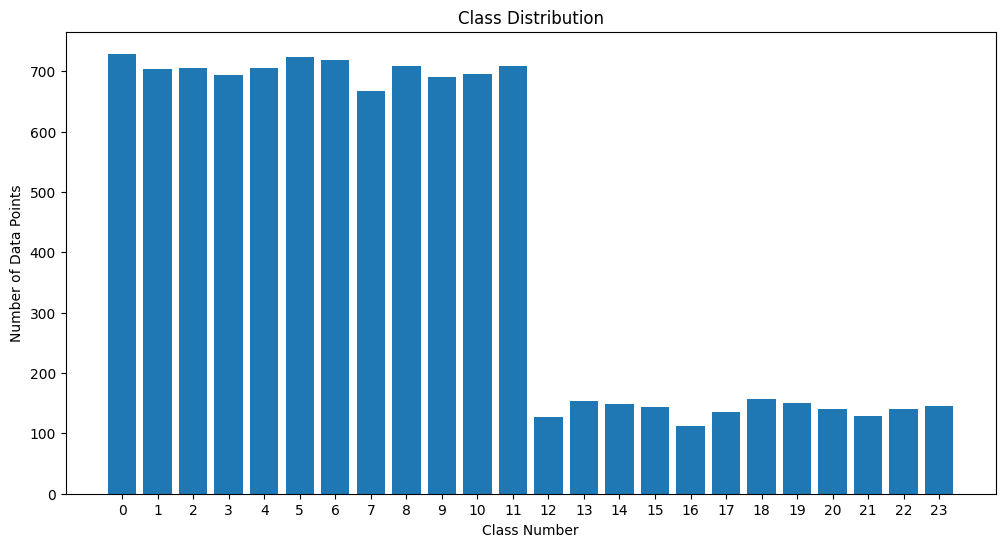

In [ ]:
class_counts = np.bincount(seen_train_y)

# Create a list of class numbers
class_numbers = list(range(len(class_counts)))

import matplotlib.pyplot as plt
# Create a bar graph to visualize the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_numbers, class_counts, tick_label=class_numbers)
plt.xlabel('Class Number')
plt.ylabel('Number of Data Points')
plt.title('Class Distribution')
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have seen_train_y containing the training labels
# Adjust the number of classes as needed
num_classes = 24

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(seen_train_y), y=seen_train_y)

# Create a dictionary of class weights
class_weight_dict = {}
for class_idx, class_weight in enumerate(class_weights):
    class_weight_dict[class_idx] = class_weight

class_weight_dict

{0: 0.5791609510745314,
 1: 0.5997277462121212,
 2: 0.5980288007554296,
 3: 0.6083693563880884,
 4: 0.5988770685579197,
 5: 0.5831606813996317,
 6: 0.5872160407974037,
 7: 0.6329960019990005,
 8: 0.5963394538606404,
 9: 0.6118961352657005,
 10: 0.6074940047961631,
 11: 0.5954983544898919,
 12: 3.324475065616798,
 13: 2.741612554112554,
 14: 2.852759009009009,
 15: 2.9525058275058274,
 16: 3.7363569321533925,
 17: 3.1044730392156863,
 18: 2.689225053078556,
 19: 2.814722222222222,
 20: 2.994385342789598,
 21: 3.2985026041666665,
 22: 2.994385342789598,
 23: 2.9117816091954025}

In [ ]:
# Assuming you have filtered_train_y containing the filtered labels
# You can adjust the threshold as needed
# HEAD TAIL SPLIT
'''threshold = 100  # Adjust this threshold based on your dataset and requirements

# Count the number of data points for each class
class_counts = np.bincount(filtered_train_y)

# Find the class indices that meet the threshold criteria
tail_class_indices = np.where(class_counts < threshold)[0]
head_class_indices = np.where(class_counts >= threshold)[0]

# Create masks to separate the data into head and tail classes
is_tail_class = np.isin(filtered_train_y, tail_class_indices)
is_head_class = np.isin(filtered_train_y, head_class_indices)

# Separate the data into head and tail classes
tail_class_data_X = filtered_train_X[is_tail_class]
tail_class_data_y = filtered_train_y[is_tail_class]

head_class_data_X = filtered_train_X[is_head_class]
head_class_data_y = filtered_train_y[is_head_class]'''


'threshold = 100  # Adjust this threshold based on your dataset and requirements\n\n# Count the number of data points for each class\nclass_counts = np.bincount(filtered_train_y)\n\n# Find the class indices that meet the threshold criteria\ntail_class_indices = np.where(class_counts < threshold)[0]\nhead_class_indices = np.where(class_counts >= threshold)[0]\n\n# Create masks to separate the data into head and tail classes\nis_tail_class = np.isin(filtered_train_y, tail_class_indices)\nis_head_class = np.isin(filtered_train_y, head_class_indices)\n\n# Separate the data into head and tail classes\ntail_class_data_X = filtered_train_X[is_tail_class]\ntail_class_data_y = filtered_train_y[is_tail_class]\n\nhead_class_data_X = filtered_train_X[is_head_class]\nhead_class_data_y = filtered_train_y[is_head_class]'

In [ ]:
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
cate_seen_train_y = to_categorical(seen_train_y, len(seen))#make train y to categorial/one hot vectors

In [ ]:
cate_seen_train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
seen_train_y

array([12,  2,  9, ...,  4, 18, 14])

In [ ]:
#Network, in the paper, I use pretrained google news embedding, here I do not use it and set the embedding layer trainable
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding, Input, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import backend as K

def Network(MAX_SEQUENCE_LENGTH = 3000, EMBEDDING_DIM = 300, nb_word = len(word_to_idx)+2, filter_lengths = [3, 4, 5],
    nb_filter = 150, hidden_dims =250):

    graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,  EMBEDDING_DIM))
    convs = []
    for fsz in filter_lengths:
        conv = Conv1D(filters=nb_filter,
                                 kernel_size=fsz,
                                 padding='valid',
                                 activation='relu')(graph_in)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)

    if len(filter_lengths)>1:
        out = Concatenate(axis=-1)(convs)
    else:
        out = convs[0]

    graph = Model(inputs=graph_in, outputs=out) #convolution layers

    emb_layer = [Embedding(nb_word,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True),
                 Dropout(0.2)
        ]
    conv_layer = [
            graph,
        ]
    feature_layers1 = [
            Dense(hidden_dims),
            Dropout(0.2),
            Activation('relu')
    ]
    feature_layers2 = [
            Dense(len(seen) ),
            Dropout(0.2),
    ]
    output_layer = [
            Activation('sigmoid')
    ]

    model = Sequential(emb_layer+conv_layer+feature_layers1+feature_layers2+output_layer)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
model = Network()
print( model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 300)         3672900   
                                                                 
 dropout (Dropout)           (None, 3000, 300)         0         
                                                                 
 model (Functional)          (None, 450)               540450    
                                                                 
 dense (Dense)               (None, 250)               112750    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 activation (Activation)     (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                6

In [ ]:
bestmodel_path = 'bestmodel.h5'

checkpointer = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
early_stopping=EarlyStopping(monitor='val_loss', patience=5)

model.fit(seen_train_X,
          cate_seen_train_y,
          epochs=100,
          batch_size=128,
          callbacks=[checkpointer, early_stopping],
          validation_split=0.2,
          class_weight=class_weight_dict)

model.load_weights(bestmodel_path)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.0708
Epoch 1: val_loss improved from inf to 0.19368, saving model to bestmodel.h5
64/64 [==============================] - 55s 691ms/step - loss: 0.3181 - accuracy: 0.0708 - val_loss: 0.1937 - val_accuracy: 0.0997


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.0856
Epoch 2: val_loss improved from 0.19368 to 0.15313, saving model to bestmodel.h5
64/64 [==============================] - 45s 704ms/step - loss: 0.2703 - accuracy: 0.0856 - val_loss: 0.1531 - val_accuracy: 0.4455
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.3098
Epoch 3: val_loss improved from 0.15313 to 0.09749, saving model to bestmodel.h5
64/64 [==============================] - 39s 608ms/step - loss: 0.2244 - accuracy: 0.3098 - val_loss: 0.0975 - val_accuracy: 0.6172
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.4842
Epoch 4: val_loss improved from 0.09749 to 0.07933, saving model to bestmodel.h5
64/64 [==============================] - 41s 640ms/step - loss: 0.1980 - accuracy: 0.4842 - val_loss: 0.0793 - val_accuracy: 0.7089
Epoch 5/100
64/64 [==============================] - ETA: 0s - loss: 0.1826 

In [ ]:
#predict on training examples for cauculate standard deviation
seen_train_X_pred = model.predict(seen_train_X)
print(seen_train_X_pred.shape)

317/317 [==============================] - 12s 33ms/step
(10133, 24)


In [ ]:
#fit a gaussian model
from scipy.stats import norm as dist_model
def fit(prob_pos_X):
    prob_pos = [p for p in prob_pos_X]+[2-p for p in prob_pos_X]
    pos_mu, pos_std = dist_model.fit(prob_pos)
    return pos_mu, pos_std

In [ ]:
seen_train_X_pred[seen_train_y==1, 1]

array([9.85150397e-01, 9.79143023e-01, 9.92367804e-01, 9.77058351e-01,
       9.91540611e-01, 9.81802940e-01, 9.85028148e-01, 9.73239362e-01,
       9.93817747e-01, 9.95275736e-01, 9.96174335e-01, 3.73902231e-01,
       9.94474351e-01, 9.97966409e-01, 8.94937217e-01, 9.64870155e-01,
       9.74985123e-01, 9.87536609e-01, 9.64998901e-01, 9.87685561e-01,
       9.66607988e-01, 9.89602268e-01, 9.98973370e-01, 9.97129261e-01,
       9.54796135e-01, 9.86570776e-01, 9.82808411e-01, 9.92377400e-01,
       9.36142266e-01, 9.52724755e-01, 9.90425050e-01, 9.98744130e-01,
       9.84116375e-01, 9.98389244e-01, 9.88321960e-01, 9.94531095e-01,
       9.91833210e-01, 9.93691802e-01, 8.84979725e-01, 9.93205905e-01,
       9.96724308e-01, 9.83204663e-01, 9.83705997e-01, 9.98580575e-01,
       9.76536751e-01, 9.95748222e-01, 6.60570443e-01, 9.96714115e-01,
       8.01247239e-01, 9.92664278e-01, 9.42758203e-01, 9.95913088e-01,
       9.14614797e-01, 9.94919360e-01, 9.96536255e-01, 9.79188383e-01,
      

In [ ]:
#calculate mu, std of each seen class
mu_stds = []
for i in range(len(seen)):
    pos_mu, pos_std = fit(seen_train_X_pred[seen_train_y==i, i])
    mu_stds.append([pos_mu, pos_std])

print( mu_stds)

[[1.0, 0.2532659776836448], [1.0, 0.22239745840716654], [1.0, 0.23068763398435194], [1.0, 0.31393179295583], [1.0, 0.19436211060253694], [1.0, 0.18633537483072082], [1.0, 0.16067463824920267], [1.0, 0.3184331370178253], [1.0, 0.3640887402312565], [1.0, 0.2955334273706855], [1.0, 0.31410519932115283], [1.0, 0.2037727962300163], [1.0, 0.3051365852606025], [1.0, 0.29348229847287954], [1.0, 0.2469284436779268], [1.0, 0.23593682926375592], [1.0, 0.2567065990963774], [1.0, 0.02568502759134975], [1.0, 0.21707438028292722], [1.0, 0.21083414626540395], [1.0, 0.1592079363892272], [1.0, 0.15122369784087691], [1.0, 0.14426584373029716], [1.0, 0.13806186364563763]]


In [ ]:
#predict on test examples
test_X_pred = model.predict(np.concatenate([seen_test_X,unseen_test_X], axis = 0))
test_y_gt = np.concatenate([seen_test_y,unseen_test_y], axis = 0)
print( test_X_pred.shape, test_y_gt.shape)

469/469 [==============================] - 16s 34ms/step
(15000, 24) (15000,)


In [ ]:
test_y_pred = []
scale = 1.
for p in test_X_pred:# loop every test prediction
    max_class = np.argmax(p)# predicted class
    max_value = np.max(p)# predicted probability
    threshold = max(0.5, 1. - scale * mu_stds[max_class][1])#find threshold for the predicted class
    if max_value > threshold:
        test_y_pred.append(max_class)#predicted probability is greater than threshold, accept
    else:
        test_y_pred.append(len(seen))#otherwise, reject


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(test_y_gt, test_y_pred)
print( 'macro fscore: ', np.mean(fscore))

macro fscore:  0.6476397665355047


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_y_gt, test_y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.43      0.74      0.54       271
           1       0.95      0.86      0.90       296
           2       0.72      0.77      0.74       294
           3       0.59      0.53      0.56       306
           4       0.54      0.64      0.58       295
           5       0.71      0.70      0.70       276
           6       0.77      0.72      0.75       281
           7       0.26      0.55      0.35       333
           8       0.19      0.65      0.30       292
           9       0.68      0.60      0.64       310
          10       0.71      0.61      0.66       305
          11       0.86      0.79      0.82       291
          12       0.67      0.29      0.41       294
          13       0.76      0.42      0.54       299
          14       0.78      0.53      0.63       293
          15       0.66      0.45      0.53       295
          16       0.57      0.41      0.48       318
          17       0.99    